# Statistics 2 - Project - Assignment #3

#### Jeremy (931215248) and Uri (300691367)
---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.style.use('ggplot')

## Load Data

load the data from a file and create the df used in previous project exercises.

Recall that the data comprises recorded observations of booking information of a hotel.

The resulted df will contain 20k rows. This will be considered as the **"entire population"** from which we sample.

In [2]:
# load data
# file downloaded from
# https://www.kaggle.com/datasets/khairullahhamsafar/hotels-booking-data-cleaned-version
# and dropped as is in the notebook

df = pd.read_csv("hotel_booking_data_cleaned.csv")


# Data preprocessing

# 1. sum of all guests in reservation
df['total_guests'] = df['adults'] + df['children'] + df['babies']

# 2. sum of all nights in reservation
df['number_of_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

# 3. binary indicator whether a weekend night included in reservation
df['weekend_included'] = df['stays_in_weekend_nights'].map(lambda x: 1 if x > 0 else 0)

# 4. First, concatenate the relevant columns and convert the type to obtain a datetime value.
df['arrival_date'] = df['arrival_date_month'].astype(str) + ' ' + df['arrival_date_day_of_month'].astype(str) + ', ' + df['arrival_date_year'].astype(str)
df['arrival_date'] = df['arrival_date'].apply(lambda x: datetime.strptime(x, "%B %d, %Y"))
# Next, identify day_0 and calculate the new column values based on it.
day_0 = df['arrival_date'].sort_values().values[0]
df['arrival_day'] = df['arrival_date'].map(lambda x: (x - day_0) / np.timedelta64(1, 'D'))

# 5. extract day of the week from the date of arrival
df['arrival_day_of_week'] = df['arrival_date'].map(lambda x: x.strftime('%a'))

# remove rows with 'total_guests' = 0 or 'number_of_nights' = 0 or 'adr' = 0
df = df.loc[(df['total_guests'] > 0) & (df['number_of_nights'] > 0) & (df['adr'] > 0)]

# remove extreme outlier (removing 1 row)
df = df.loc[df['adr'] < 5000] #.reset_index(drop=True)

# 6. create another new column
df['adr_per_guest'] = df['adr'] / df['total_guests']


# narrowing down data

# select only records from top 1 country, and top 1 hotel
df = df.loc[(df['hotel'] == 'City Hotel') & (df['country'] == 'PRT')]

# selecting features
selected_columns = [
    'is_canceled', 'lead_time', 'arrival_date_year',
    'arrival_date_month', 'arrival_day_of_week', 'arrival_day',
    'number_of_nights', 'weekend_included', 'is_repeated_guest',
    'deposit_type', 'adr', 'total_guests', 'adr_per_guest'
    ]
df = df[selected_columns].copy()


# sample 20000 random data points
n = 20000
df = df.sample(n, random_state=27).reset_index(drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_canceled          20000 non-null  int64  
 1   lead_time            20000 non-null  int64  
 2   arrival_date_year    20000 non-null  int64  
 3   arrival_date_month   20000 non-null  object 
 4   arrival_day_of_week  20000 non-null  object 
 5   arrival_day          20000 non-null  float64
 6   number_of_nights     20000 non-null  int64  
 7   weekend_included     20000 non-null  int64  
 8   is_repeated_guest    20000 non-null  int64  
 9   deposit_type         20000 non-null  object 
 10  adr                  20000 non-null  float64
 11  total_guests         20000 non-null  float64
 12  adr_per_guest        20000 non-null  float64
dtypes: float64(4), int64(6), object(3)
memory usage: 2.0+ MB


## Part 1 - Linear Regression

### 1. Chosen Variables
The dependent variable will be **'adr_per_guest'** Average Daily Rate per guest, i.e., the average rental income per paid occupied room divided by number of guests in the reservation. This is a continuous variable.

The explanatory variables will be:
1. **'total_guests'** - number of guest in reservation. a descrete variable that ranges from 1 to 5 (in the "entire population").
2. **'number_of_nights'** - The total number of nights booked in a reservation. A discrete variable.
3. **'weekend_included'** - a binary variable which indicates if the reservation includes a weekend night (Sat or Sun)
4. **'lead_time'** - number of days between booking date and arrival date. An ordinal variable that ranges from 0 to 629 (in the "entire population"), represented by integer values.

### Research Question
How do the explanatory variables impact the dependent variable?

### 2. Sample 200 observation

In [4]:
vars = ['total_guests', 'number_of_nights', 'weekend_included', 'lead_time', 'adr_per_guest']
k = 200
sample_df = df[vars].sample(k, random_state=27).reset_index(drop=True)

### 3. Exploratory Data Analysis

Meaningful statistical values

In [5]:
sample_df.describe()

,total_guests,number_of_nights,weekend_included,lead_time,adr_per_guest
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.780000,2.405000,0.400000,140.875000,57.189329
std,0.531992,1.264504,0.491127,148.905283,26.659159
min,1.000000,1.000000,0.000000,0.000000,18.000000
25%,1.000000,2.000000,0.000000,20.000000,34.750000
50%,2.000000,2.000000,0.000000,87.000000,49.150000
75%,2.000000,3.000000,1.000000,213.000000,71.743750
max,4.000000,9.000000,1.000000,626.000000,146.600000


#### Distribution of the variables in the sample

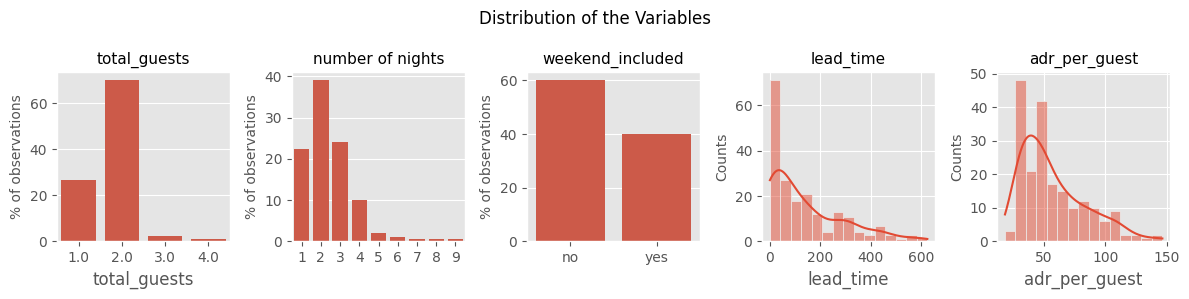

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(12,3))

# total guests
sns.countplot(ax=ax[0], x="total_guests", data=sample_df, stat='percent')
ax[0].set_title('total_guests', fontsize=11)
ax[0].set_ylabel('% of observations',fontsize=10)

# number of nights
sns.countplot(ax=ax[1], x=sample_df['number_of_nights'], stat='percent')
ax[1].set_title('number of nights', fontsize=11)
ax[1].set_xlabel('')
ax[1].set_ylabel("% of observations", fontsize=10)

# weekend
sns.countplot(ax=ax[2], x=sample_df['weekend_included'], stat='percent')
ax[2].set_xticks([0,1])
ax[2].set_xticklabels(['no', 'yes'])
ax[2].set_title('weekend_included', fontsize=11)
ax[2].set_xlabel('')
ax[2].set_ylabel("% of observations", fontsize=10)


# lead_time
sns.histplot(data=sample_df, x="lead_time", bins=15, kde=True, ax=ax[3])
ax[3].set_ylabel("Counts", fontsize=10)
ax[3].set_title('lead_time', fontsize=11)

# adr_per_guest
sns.histplot(data=sample_df, x="adr_per_guest", bins=15, kde=True, ax=ax[4])
ax[4].set_ylabel("Counts", fontsize=10)
ax[4].set_title('adr_per_guest', fontsize=11)

fig.suptitle('Distribution of the Variables')
plt.tight_layout()
plt.show()


#### Notes:
- There are no missing values.
- The distribution of 'lead_time' appears to resemble that of an exponential distribution.
- 'adr_per_guest' exhibits characteristics similar to a chi-squared distribution.
- The distribution of the sample across the 'weekend' variable seems fairly even, but there is less balance in the distribution across the 'total_guests' and 'number_of_nights' variables.

#### The relationship between X and Y

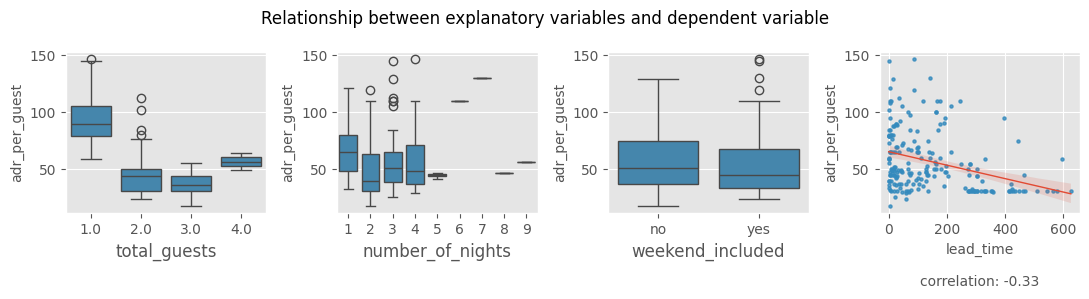

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(11,3))

# total guests
sns.boxplot(ax=ax[0], data=sample_df, x='total_guests', y='adr_per_guest', color='#348ABD')
ax[0].set_ylabel("adr_per_guest", fontsize=10)


# weekend
sns.boxplot(ax=ax[2], data=sample_df, x='weekend_included', y='adr_per_guest', color='#348ABD')
ax[2].set_xticks([0,1])
ax[2].set_xticklabels(['no', 'yes'])
ax[2].set_ylabel("adr_per_guest", fontsize=10)


# number of nights
sns.boxplot(ax=ax[1], data=sample_df, x='number_of_nights', y='adr_per_guest', color='#348ABD')
ax[1].set_ylabel("adr_per_guest", fontsize=10)

# lead_time
sns.regplot(ax=ax[3], data=sample_df, x='lead_time', y='adr_per_guest',
            scatter_kws = {"s":5}, color='#348ABD',
            line_kws = {"color": "#E24A33", "linewidth":1},
            ci=95)
ax[3].set_ylabel("adr_per_guest", fontsize=10)
corr = sample_df[['lead_time', 'adr_per_guest']].corr().iloc[0,1]
ax[3].set_xlabel(f"lead_time\n\ncorrelation: {round(corr, 2)}", fontsize=10)

fig.suptitle("Relationship between explanatory variables and dependent variable")
plt.tight_layout()
plt.show()

#### Notes:
- It seems that individual guests pay more compared to multiple guests, but also, when the group size exceeds 3, each person pays more. This could indicate a requirement for larger rooms that come with higher costs. Alternatively, this could be due to insufficient sample sizes.
- It's somewhat unexpected that guests don't pay higher rates on weekends (on average).
- Regarding 'lead_time,' as anticipated, booking earlier is associated with lower costs per guest. The Pearson correlation coefficient is -0.33.
- It appears that the group size and booking in advance have the greatest influence on the average rate per guest among the four variables.

### 4. Caculating the Coefficient Vector $\hat{\beta}$

#### Create the model

In [8]:
X = sample_df.iloc[:, :-1]
y = sample_df.iloc[:, -1]

# add column of 1's to X at position 0
X.insert(0, "x_0", [1] * sample_df.shape[0])

beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

print("The estimator for beta is:")
for i, (beta_i, feature) in enumerate(zip(beta_hat, X.columns)):
  print(f"beta_{i} = {round(beta_i, 3)} ({feature})")

The estimator for beta is:
beta_0 = 115.825 (x_0)
beta_1 = -33.062 (total_guests)
beta_2 = 3.454 (number_of_nights)
beta_3 = -4.247 (weekend_included)
beta_4 = -0.045 (lead_time)


#### Notes
- Based on the estimated coefficient $\hat{\beta}$, we observe that the variable having the most significant impact on the dependent variable is **'total_guest'**: an addition of 1 person to the group decreasing the amount each person pays by 33 units.
- **'lead_time'** seems to be the least impactful variable, contrary to our initial hypothesis. A one-day earlier booking only decreases the amount paid per person by 0.045 units.
- Similarly, increasing the number of nights by one results in an increase of 3.454 units in the amount paid per person.
- As seen earlier, bookings that include weekend nights are 4.247 units cheaper than those that do not include weekends.
- $\hat{\beta_0}$ represents the amount added to each booking and can be likened to VAT (Value Added Tax).


### 5. ANOVA table, $R^2$ and $R^2_{adj}$ and F-test

In [9]:
y_hat = (X @ beta_hat.values.reshape(-1,1)).values.reshape(-1)

SS_Res = np.sum(np.square(y - y_hat))
SS_R = np.sum(np.square(y_hat - y.mean()))
SS_T = SS_Res + SS_R

n = 200
k = 4
p = k + 1

MS_T = SS_T / (n-1)
MS_R = SS_R / k
MS_Res = SS_Res / (n - p)

R_2 = SS_R / SS_T
R_2_adj = 1 - (MS_Res / MS_T)

F = MS_R / MS_Res


# create the table
from tabulate import tabulate

data = [
    ["Regression", SS_R, p-1, round(MS_R,3), round(F,3)],
    ["Residual", SS_Res, n-p, round(MS_Res,3), ""],
    ["Total", SS_T, n-1, "", ""],
]

headers = ["Source of Variation", "SS", "DF", "MS", "F"]

print("ANOVA TABLE:\n")
print(tabulate(data, headers=headers, tablefmt="grid"))

print(f"\nR_2 = {round(R_2,3)}\nR_2_adj = {round(R_2_adj,3)}")

# calculate f-critical value for the f test
from scipy.stats import f

alpha = 0.05

f_critical = f.ppf(1 - alpha, k, n-p)
print("\nF-test:\n")
print(f"The {1-alpha}% quantile of the F-distribution is: {round(f_critical,3)}")

print(f"Conclusion: we {'DO reject' if F > f_critical else 'DONT reject'} the null hypothesis (which states that beta_j = 0 for all j)")


ANOVA TABLE:

+-----------------------+----------+------+-----------+--------+
| Source of Variation   |       SS |   DF | MS        | F      |
+=======================+==========+======+===========+========+
| Regression            |  77176.1 |    4 | 19294.037 | 58.553 |
+-----------------------+----------+------+-----------+--------+
| Residual              |  64255.3 |  195 | 329.514   |        |
+-----------------------+----------+------+-----------+--------+
| Total                 | 141431   |  199 |           |        |
+-----------------------+----------+------+-----------+--------+

R_2 = 0.546
R_2_adj = 0.536

F-test:

The 0.95% quantile of the F-distribution is: 2.418
Conclusion: we DO reject the null hypothesis (which states that beta_j = 0 for all j)


### 6. CI for $\beta^*_i$

We saw in class that an aproximated $1-\alpha$ CI for $\beta^*_j$ is:
\begin{equation}
  [\hat{\beta}_j \pm z_{1-\frac{\alpha}{2}} \hat{se}(\hat{\beta}_j)]
\end{equation}
where:
\begin{equation}
  \hat{se}(\hat{\beta}_j) = \sqrt{\hat{\sigma}_\epsilon^2C_{jj}}
\end{equation}
for
\begin{equation}
  C = (X^TX)^{-1}
\end{equation}
and
\begin{equation}
  \hat{\sigma}_\epsilon^2 = \frac{1}{n-p}\sum_{i=1}^n{(y-\hat{y})^2}
\end{equation}

In [10]:
from scipy import stats

alpha = 0.05
C = np.linalg.inv(X.T @ X)
sigma_epsilon_hat = np.sum((y - y_hat) ** 2) / (X.shape[0] - X.shape[1])
standard_errors = np.sqrt(np.diag(C * sigma_epsilon_hat))

z = stats.norm.ppf(1- alpha/2)

# Calculate the confidence intervals for the coefficients
confidence_intervals = np.column_stack((
    beta_hat - z * standard_errors,
    beta_hat + z * standard_errors
))

print("Confidence Intervals:")
for i, interval in enumerate(confidence_intervals):
    print(f"beta_{i}: CI: {interval}")

Confidence Intervals:
beta_0: CI: [106.07178966 125.57913507]
beta_1: CI: [-37.87385265 -28.25013174]
beta_2: CI: [1.18114039 5.72698409]
beta_3: CI: [-10.10894511   1.61435129]
beta_4: CI: [-0.06252831 -0.02824561]


#### $\hat{\beta}$ of the entire population

In [11]:
population = df[vars]
X_pop = population.iloc[:, :-1]
y_pop = population.iloc[:, -1]

# add column of 1's to X at position 0
X_pop.insert(0, "x_0", [1] * population.shape[0])

beta_hat_pop = np.linalg.inv(X_pop.T @ X_pop) @ X_pop.T @ y_pop

print("The estimator for beta of the entire population is:")
for i, (beta_i, feature) in enumerate(zip(beta_hat_pop, X_pop.columns)):
  print(f"beta_{i} = {round(beta_i, 3)} ({feature})")


# check if is in CI of the sample
print("\nIs in sample CI:\n")
for i, (b, ci) in enumerate(zip(beta_hat_pop, confidence_intervals)):
  is_in = "IS" if (b >= ci[0] and b <= ci[1]) else "IS NOT"
  # print(f"beta_{i} {is if}")
  print(f"beta_{i} {is_in} in CI of the sample which was: {ci}")

The estimator for beta of the entire population is:
beta_0 = 117.68 (x_0)
beta_1 = -30.69 (total_guests)
beta_2 = 0.952 (number_of_nights)
beta_3 = -0.416 (weekend_included)
beta_4 = -0.047 (lead_time)

Is in sample CI:

beta_0 IS in CI of the sample which was: [106.07178966 125.57913507]
beta_1 IS in CI of the sample which was: [-37.87385265 -28.25013174]
beta_2 IS NOT in CI of the sample which was: [1.18114039 5.72698409]
beta_3 IS in CI of the sample which was: [-10.10894511   1.61435129]
beta_4 IS in CI of the sample which was: [-0.06252831 -0.02824561]


### 7. Test if each of $\beta^*_j$ is non-zero

Under the assumptions of a linear model, i.e.:
\begin{equation}
  \text{(1) Linearity: } \mathbb{E}[y|X] = \beta^*X \\
  \text{(2) }\epsilon_i \text{ are i.i.d with } \mathbb{E}[\epsilon_i] = 0 \text{ and } Var[\epsilon_i] = \sigma^2_{\epsilon_i} \\
\end{equation}

we saw in class that under the assumption that $X^TX$ is invertible our OLS estimator for $\beta^*$, $\hat{\beta} = (X^TX)^{-1}X^Ty$ is assymptotically normal:
\begin{equation}
  \hat{\beta} \approx N(\beta^*, \sigma_\epsilon^2C)
\end{equation}
for $C = (X^TX)^{-1}$

Under these assumption we can use the Wald Test which is:
\begin{equation}
  H_0: \hat{\beta_j} = 0\\
  H_1:\hat{\beta_j} \neq 0\\
  T.S.: W = \frac{\hat{\beta_j}}{\sqrt{\hat{\sigma}_\epsilon^2C_{jj}}} \\
  R.R.: |W| > z_{1-\frac{\alpha}{2}}
\end{equation}

In [12]:
alpha = 0.05
C = np.linalg.inv(X.T @ X)
sigma_epsilon_hat = np.sum((y - y_hat) ** 2) / (X.shape[0] - X.shape[1])
standard_errors = np.sqrt(np.diag(np.linalg.inv(X.T @ X) * sigma_epsilon_hat))

z = stats.norm.ppf(1- alpha/2)

W = beta_hat / standard_errors

print(f"Z = {round(z,3)}")
for i, w in enumerate(W):
  is_reject = np.abs(w) > z
  print(f"W_{i} = {round(w,3)}. The null hypothesis {'is' if is_reject else 'is NOT'} rejected for beta_{i}")
# W, np.abs(W) > z

Z = 1.96
W_0 = 23.275. The null hypothesis is rejected for beta_0
W_1 = -13.467. The null hypothesis is rejected for beta_1
W_2 = 2.978. The null hypothesis is rejected for beta_2
W_3 = -1.42. The null hypothesis is NOT rejected for beta_3
W_4 = -5.19. The null hypothesis is rejected for beta_4


### 8. Residual Analysis and QQ-Plot

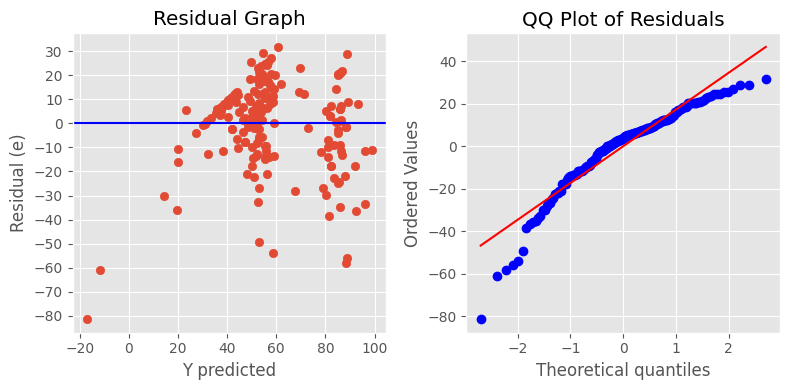

In [13]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

residuals = y_hat - y
ax[0].scatter(y_hat,residuals)
ax[0].axhline(y = 0, color = 'b', linestyle = '-')
ax[0].set_yticks(np.arange(-80, 40, 10))
ax[0].set_ylabel("Residual (e)")
ax[0].set_xlabel("Y predicted")
ax[0].set_title("Residual Graph")

# residuals QQ-plot
stats.probplot(residuals, dist="norm", plot=ax[1])
ax[1].set_title('QQ Plot of Residuals')

plt.tight_layout()
plt.show()

#### Notes:
Residual Analysis:
- The linearity assumption seems reasonable: except for two outliers in the bottom left, the points appear to be randomly distributed around the zero line.
- The assumption of constant variance (homoscedasticity) also seems reasonable because (apart from those two outliers)the scatter of the residuals around the zero line is relatively constant, indicating consistent variability across the range of the independent variable.

QQ-plot:
- The normality assumption of the noise appears to be questionable, as the residuals do not conform very well to the normal distribution.

### 9.Prediction

Sample 1000 new rows and get predictions

In [14]:
# Merge df of population with sample_df on common columns to find rows not in sample_df
new_sample_df = df[vars].merge(sample_df, indicator=True, how='outer').query('_merge == "left_only"').drop('_merge', axis=1)

# sample new rows from rows not in the first sample we used
n_new = 1000
new_sample_df = new_sample_df.sample(n_new, random_state=27).reset_index(drop=True)

# verify that new sample doesn't contain rows from first sample
is_in = sample_df.merge(new_sample_df, indicator=True, how='outer')
assert is_in['_merge'].value_counts()['both'] == 0


X_new = new_sample_df.iloc[:, :-1]
y_new = new_sample_df.iloc[:, -1]

# add column of 1's to X_new at position 0
X_new.insert(0, "x_0", [1] * new_sample_df.shape[0])

# predict
y_new_hat = (X_new @ beta_hat.values.reshape(-1,1)).values.reshape(-1)

#### Calculate CI for the prediction (and its expectation)

Like we saw in class, the CI for the prediction is:
\begin{equation}
  [\hat{Y}_{new} \pm z_{1-\frac{\alpha}{2}} \sqrt{\sigma^2_{\epsilon}(X_{new}^T C X_{new} + 1)}]
\end{equation}

In [15]:
standard_errors_new = np.sqrt(sigma_epsilon_hat * (np.diag(X_new.values @ C @ X_new.values.T) + 1))

alpha = 0.05
z = stats.norm.ppf(1- alpha/2)

# Calculate the confidence intervals for the predictions
confidence_intervals_new = np.column_stack((
    y_new_hat - z * standard_errors_new,
    y_new_hat + z * standard_errors_new
))

# ceheck how many CI contain true y
ci_contain_true = np.zeros(y_new.shape[0])
for i, ci in enumerate(confidence_intervals_new):
  ci_contain_true[i] = (y_new[i] >= ci[0] and y_new[i] <= ci[1])

print(f"Percentage of confidence intervals which contain the true value is: {ci_contain_true.mean() * 100}%")

Percentage of confidence intervals which contain the true value is: 91.3%


#### Notes:
The percentage of confidence intervals that include the true value is nearly 95%. This suggests that our assumptions of linearity and homoscedasticity are likely valid.

### 10. First Order Interactions

In [16]:
# add first order interactions
Z = X.copy()
Z['Z_12'] = X.iloc[:, 1] * X.iloc[:, 2]
Z['Z_13'] = X.iloc[:, 1] * X.iloc[:, 3]
Z['Z_14'] = X.iloc[:, 1] * X.iloc[:, 4]
Z['Z_23'] = X.iloc[:, 2] * X.iloc[:, 3]
Z['Z_24'] = X.iloc[:, 2] * X.iloc[:, 4]
Z['Z_34'] = X.iloc[:, 3] * X.iloc[:, 4]

beta_hat_z = np.linalg.inv(Z.T @ Z) @ Z.T @ y

print("The estimator for THIS beta is:")
for i, (beta_i, feature) in enumerate(zip(beta_hat_z, Z.columns)):
  print(f"beta_{i} = {round(beta_i, 3)} ({feature})")

The estimator for THIS beta is:
beta_0 = 99.981 (x_0)
beta_1 = -21.737 (total_guests)
beta_2 = 12.33 (number_of_nights)
beta_3 = -21.164 (weekend_included)
beta_4 = -0.046 (lead_time)
beta_5 = -6.068 (Z_12)
beta_6 = 10.577 (Z_13)
beta_7 = -0.017 (Z_14)
beta_8 = -0.506 (Z_23)
beta_9 = 0.014 (Z_24)
beta_10 = 0.001 (Z_34)


### Which model is better

#### Likelihood Ratio Test
Under the assumption that $Y_i - \hat{Y_i} = e_i \sim N(0,\sigma^2_\epsilon)$ we get that the log-likelihood function is
\begin{equation}
  l(\beta) = -\frac{n}{2}(\log{(2\pi\sigma^2_\epsilon)} - \frac{1}{2\pi\sigma^2_\epsilon}\sum_{i=1}^n (y_i-\hat{y_i})^2
\end{equation}

Where both $\hat{y}, \sigma^2_\epsilon$ depend on the estimator $\hat{\beta}$.

The test is:
\begin{equation}
  H_o: \hat\beta = (X^TX)^{-1}X^Ty \text{ (i.e. the simple model)} \\
  H_1: \hat\beta = (Z^TZ)^{-1}Z^Ty \text{ (i.e. the larger model)} \\
  T.S: \ \lambda = 2 (l(\hat\beta_{large}) - l(\hat\beta_{simple})) \\
  R.R.: \lambda > \chi^2_{(6),1-\alpha}
\end{equation}

The degree of freedom is 6 as the number of coefficients added to the larger model compared to the simple model.



In [17]:
y_hat_large = (Z @ beta_hat_z.values.reshape(-1,1)).values.reshape(-1)
sigma_epsilon_simple_hat = sigma_epsilon_hat # computed earlier
sigma_epsilon_large_hat = np.sum((y - y_hat_large) ** 2) / (Z.shape[0] - Z.shape[1])

def log_likelihood_beta(sigma_hat, y_hat_):
  n = y_hat_.shape[0]
  a = 2 * np.pi * sigma_hat
  return (-y_hat.shape[0] / 2 * np.log(a) - 1 / (a) * np.sum((y - y_hat_) ** 2))

lmbda = 2 * (log_likelihood_beta(sigma_epsilon_large_hat, y_hat_large) - log_likelihood_beta(sigma_epsilon_simple_hat, y_hat))

alpha = 0.05
critical_chi = stats.chi2.ppf(1-alpha, 6)

print(f"Lambda = {round(lmbda,3)}, critical chi value is {round(critical_chi,3)}")
print(f"We {'reject' if lmbda > critical_chi else 'DO NOT reject'} the null hypothesis")

Lambda = 5.638, critical chi value is 12.592
We DO NOT reject the null hypothesis


This implies that a larger model may not necessarily be superior; in other words, the inclusion of six additional features does not appear to have a significant impact.

#### AIC and BIC scores
We can compute these scores for both of the models based on the log-likelihood we computed above.

For both of the scores - the higher the better.

In [18]:
# AIC
aic_simple = log_likelihood_beta(sigma_epsilon_simple_hat, y_hat) - X.shape[1]
aic_large = log_likelihood_beta(sigma_epsilon_large_hat, y_hat_large) - Z.shape[1]
print("AIC score")
print(f"simple model: {round(aic_simple,3)}, larger model: {round(aic_large,3)}")

bic_simple = log_likelihood_beta(sigma_epsilon_simple_hat, y_hat) - X.shape[1] / 2 * np.log(X.shape[0])
bic_large = log_likelihood_beta(sigma_epsilon_large_hat, y_hat_large) - Z.shape[1] / 2 * np.log(Z.shape[0])
print("BIC score")
print(f"simple model: {round(bic_simple,3)}, larger model: {round(bic_large,3)}")

AIC score
simple model: -799.585, larger model: -802.766
BIC score
simple model: -807.831, larger model: -820.907


Again, we observe that the simple model outperforms the larger one according to these two scoring methods.

**Conclusion:** the simple model is better.

## Part 2 - Logistic Regression

# A reminder of our Data
The dataset [(link to kaggle page)](https://www.kaggle.com/datasets/khairullahhamsafar/hotels-booking-data-cleaned-version) comprises recorded observations of booking information for two hotels.

We removed columns deemed less relevant, introduced new ones for exploration, and refined the dataset by sampling records from the country ('PRT') and the hotel ('City Hotel') with the highest booking numbers.

#### The new columns we created
1. Sum all guests - adults, children, babies - to one column
2. Sum all stayed nights (weekdays + weekends nights)
3. Generate a binary indicator that equals 1 if the reservation includes weekend nights (Saturday or Sunday).
4. Generate a numeric variable that represents the day of arrival within the range of recorded dates. Set the first recorded day of arrival to 0, and, for instance, a reservation recorded a week later would have the value 7 on that column.
5. Generate 'arrival day of the week' categorical column.
6. Calculate averge cost per guest in reservation

The resulting dataset consists of **20,000** rows with **no missing values**, and includes the following **13 columns**:

| column |type | description |
|-------|-------|----
|is_canceled | binary | was the reservation cancelled|
|lead_time |int |number of days between booking date and arrival date|
|arrival_date_year | int | year of arrival|
|arrival_date_month | category | month of arrival|
|arrival_day_of_week | category | day of arrival (Sun, Mon, etc.)|
|arrival_day | int | number of days between date of arrival to first recorded date of arrival |
|number_of_nights| int| number of nights stayed|
|weekend_included| binary| 1 if reservation include Sat or Sun night|
|is_repeated_guest | binary | 1 if guest stayed in the hotel before|
|deposit_type | category | type of deposit made by the guest
|adr |float | Average Daily Rate, i.e., the average rental income per paid occupied room.
|total_guests | int | number of guests (adults and childern)|
|adr_per_guest | float | adr / total_guests

**QUESTION 1**

### Chosen Variables
The dependent variable will be **'is_canceled'**, which is a binary value : 1 if the booking has been cancelled and 0 otherwise.

The explanatory variables will be:
1. **'adr_per_guest'**
2. **'total_guests'**
3. **'lead_time'**

### Research Question
Our question is : how do the average daily rate per guest (*adr_per_guest*), number of guests (*total_guests*) and number of days between booking date and arrival date (*lead_time*) affect the booking cancellation (*is_canceled*).

**QUESTION 2**

In [3]:
vars = ['adr_per_guest', 'total_guests', 'lead_time', 'is_canceled']
k = 200
df_sample = df[vars].sample(k, random_state=20).reset_index(drop=True)

**QUESTION 3**

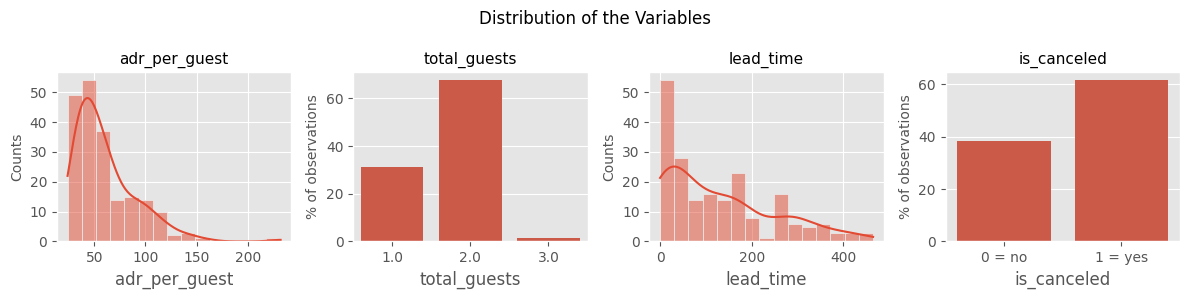

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(12,3))

# adr_per_guest
sns.histplot(data=df_sample, x="adr_per_guest", bins=15, kde=True, ax=ax[0])
ax[0].set_ylabel("Counts", fontsize=10)
ax[0].set_title('adr_per_guest', fontsize=11)

# total guests
sns.countplot(ax=ax[1], x="total_guests", data=df_sample, stat='percent')
ax[1].set_title('total_guests', fontsize=11)
ax[1].set_ylabel('% of observations',fontsize=10)

# lead_time
sns.histplot(data=df_sample, x="lead_time", bins=15, kde=True, ax=ax[2])
ax[2].set_ylabel("Counts", fontsize=10)
ax[2].set_title('lead_time', fontsize=11)

# is_canceled
sns.countplot(ax=ax[3], x=df_sample['is_canceled'], stat='percent')
ax[3].set_xticks([0,1])
ax[3].set_xticklabels(['0 = no', '1 = yes'])
ax[3].set_title('is_canceled', fontsize=11)
ax[3].set_xlabel('is_canceled')
ax[3].set_ylabel("% of observations", fontsize=10)


fig.suptitle('Distribution of the Variables')
plt.tight_layout()
plt.show()



#### Notes:
- There are no missing values.

- 'adr_per_guest' exhibits characteristics similar to a chi-squared distribution.
- The distribution across the 'total_guests' is unbalanced.
- The distribution of 'lead_time' appears to resemble that of an exponential distribution.
- The distribution of the sample across the 'is_canceled' variable seems fairly even if we can notice that there is lightly more canceled bookings.

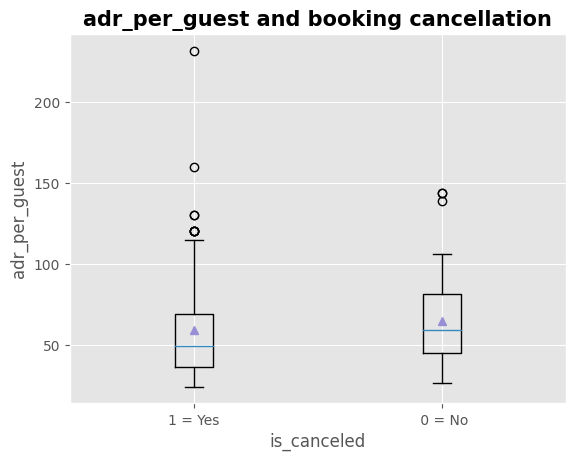

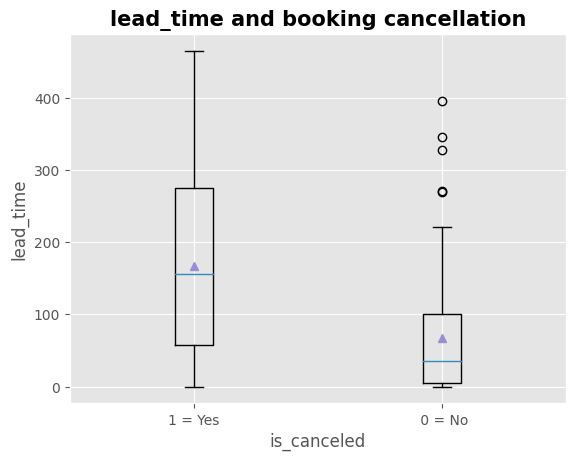

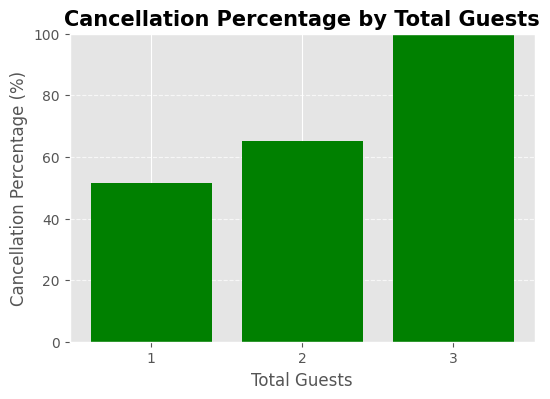

In [5]:
def box_plot(y_col, df):
  plt.boxplot([df[df["is_canceled"] == 1][y_col], df[df["is_canceled"] == 0][y_col]], showmeans=True, labels = ["1 = Yes", " 0 = No"])
  plt.title(f"{y_col} and booking cancellation",size=15, fontweight="bold")
  plt.xlabel("is_canceled")
  plt.ylabel(y_col)
  plt.plot()
  plt.show()

for y_col in vars :
  if(y_col != 'is_canceled' and y_col != 'total_guests'):
    box_plot(y_col, df_sample)

cancel_percentage = df_sample.groupby('total_guests')['is_canceled'].mean() * 100

plt.figure(figsize=(6, 4))
plt.bar(cancel_percentage.index, cancel_percentage.values, color='green')
plt.xlabel('Total Guests')
plt.ylabel('Cancellation Percentage (%)')
plt.title('Cancellation Percentage by Total Guests', size=15, fontweight="bold")
plt.xticks(cancel_percentage.index)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Notes:
- It seems that all explanatory variables affect the value of is_canceled.

- We can notice that the higher the adr_per_guest value is, we have less cancellations.
- It seems that the higher the lead_time is, the less the booking is subject to be cancelled. This is the explanatory variable with the largest effect on the Y value (is_canceled).
- The total_guests variable seems also to have an effect on the is_canceled variable. The more the number of guests for one booking, the more it is subject to cancellation. Moreover, we have to be careful of this consideration because of the lack of balance of this variable as we have seen before.

**QUESTION 4**

In [49]:
from sklearn.linear_model import LogisticRegression

X = df_sample[['adr_per_guest','total_guests','lead_time']].to_numpy()
y = df_sample['is_canceled'].to_numpy()
X = np.c_[np.ones(X.shape[0]), X]
model = LogisticRegression(penalty=None, fit_intercept=False).fit(X,y)
beta_estimators = model.coef_[0]
print(f"The coefficients are: {beta_estimators}")
print()

for i in range(1,len(beta_estimators)):
  print(f"if X{i} grows by 1 unit than the explained variable grows by : {np.exp(beta_estimators[i])}")

The coefficients are: [-2.08112491  0.00683577  0.65937943  0.00930877]

if X1 grows by 1 unit than the explained variable grows by : 1.0068591909630569
if X2 grows by 1 unit than the explained variable grows by : 1.9335920417404295
if X3 grows by 1 unit than the explained variable grows by : 1.0093522308578986


**QUESTION 5**

In [30]:
from scipy import stats

def pi(i):
  beta_T_X_i = np.matmul(beta_estimators.T, X[i])

  return np.exp(beta_T_X_i)/(1 + np.exp(beta_T_X_i))

X_all = df[['adr_per_guest','total_guests','lead_time']].to_numpy()
y_all = df['is_canceled'].to_numpy()
X_all = np.c_[np.ones(X_all.shape[0]), X_all]

model_all = LogisticRegression(penalty=None, fit_intercept=False).fit(X_all, y_all)
beta_estimator_all = model_all.coef_[0]

diagonal = [pi(i)*(1-pi(i)) for i in range(X.shape[0])]
V = np.diag(diagonal)
C = np.linalg.inv(X.T@V@X)
norm_quantile = stats.norm.ppf(0.975)

for i, variable in zip(range(beta_estimators.shape[0]), ['Beta0', 'adr_per_guest', 'total_guests', 'lead_time']):
  std_estimate = (C[i][i])**(1/2)
  CI_beta_i = [beta_estimators[i] - norm_quantile*std_estimate, beta_estimators[i] + norm_quantile*std_estimate]

  print(f"Confidence Interval for Beta{i} is: {CI_beta_i}")
  print(f"Is the CI of {variable} in the sampled data contains the estimator of the original data ? : {beta_estimator_all[i] >= CI_beta_i[0] and beta_estimator_all[i] <= CI_beta_i[1]}")
  print()

Confidence Interval for Beta0 is: [-4.431154455413555, 0.2689046305816616]
Is the CI of Beta0 in the sampled data contains the estimator of the original data ? : True

Confidence Interval for Beta1 is: [-0.007903354773379976, 0.021574902241184496]
Is the CI of adr_per_guest in the sampled data contains the estimator of the original data ? : True

Confidence Interval for Beta2 is: [-0.25539862230249977, 1.574157491552904]
Is the CI of total_guests in the sampled data contains the estimator of the original data ? : True

Confidence Interval for Beta3 is: [0.005720176578695599, 0.01289736244221426]
Is the CI of lead_time in the sampled data contains the estimator of the original data ? : True



**QUESTION 6**

In [31]:
# We now look at interactions between variables
x_1 = df_sample['adr_per_guest'].to_numpy()
x_2 = df_sample['total_guests'].to_numpy()
x_3 = df_sample['lead_time'].to_numpy()
y = df_sample['is_canceled'].to_numpy()

x_12 = np.multiply(x_1, x_2)
x_13 = np.multiply(x_1, x_3)
x_23 = np.multiply(x_2, x_3)

# Simulated data for explanatory variables (X1, X2, X3) and explained variable (Y)
X_200sample = np.array([x_1, x_2, x_3]).T

# Add a column of ones to represent the intercept term
X_200sample = np.column_stack((np.ones(X_200sample.shape[0]), X_200sample))

# Concatenate arrays along the second axis to form the final input matrix
X_interacted = np.c_[X_200sample, x_12]
X_interacted = np.c_[X_interacted, x_13]
X_interacted = np.c_[X_interacted, x_23]

y = df_sample['is_canceled'].to_numpy()

interacted_Logistic_model = LogisticRegression(penalty=None, fit_intercept=False).fit(X_interacted,y)
interacted_beta_est = interacted_Logistic_model.coef_[0]

print(f"The coefficients of the interacted sample are: {interacted_beta_est}")

The coefficients of the interacted sample are: [ 2.23420555e-03  1.39761781e-02  5.46097149e-01 -1.97466671e-02
 -2.44684376e-02  1.77703128e-04  1.06551648e-02]


In [32]:
# Fit both the null (simpler) model and alternative (more complex) model
model_null = LogisticRegression(penalty=None, fit_intercept=False)
X = X_200sample
model_null.fit(X, y)

model_alt = LogisticRegression(penalty=None, fit_intercept=False)
model_alt.fit(X_interacted, y)

# Calculate the predicted probabilities for each model
probs_null = model_null.predict_proba(X)[:, 1]
probs_alt = model_alt.predict_proba(X_interacted)[:, 1]

# Calculate the log-likelihoods for each model
log_likelihood_null = np.sum(np.log(probs_null))
log_likelihood_alt = np.sum(np.log(probs_alt))

# Calculate the likelihood ratio statistic
lr_statistic = -2 * (log_likelihood_null - log_likelihood_alt)

# Calculate the degrees of freedom as the difference in the number of parameters
degree_of_freedom = (X_interacted.shape[1] - X.shape[1])

# Set the significance level (alpha)
alpha = 0.05

# Perform the likelihood ratio test and compare to the critical value
critical_value = stats.chi2.ppf(1 - alpha, degree_of_freedom)

if lr_statistic > critical_value:
    print("Reject the null hypothesis")
    print("The more complex model is better.")
else:
    print("Fail to reject the null hypothesis")
    print("The simpler model is sufficient.")

Fail to reject the null hypothesis
The simpler model is sufficient.


In [33]:
# We are now interested by the best model based on BIC criterion

n_samples = len(y)

# Calculate the number of parameters for each model
n_params_null = X.shape[1]
n_params_alt = X_interacted.shape[1]

# Calculate the BIC for each model
bic_null = -2 * log_likelihood_null + n_params_null * np.log(n_samples)
bic_alt = -2 * log_likelihood_alt + n_params_alt * np.log(n_samples)

if bic_null < bic_alt:
    print("The simpler model (null) is preferred based on BIC criterion.")
else:
    print("The more complex model (alternative) is preferred based on BIC criterion.")

The simpler model (null) is preferred based on BIC criterion.


According to both methods we've performed in order to choose the best model (Likelihood ratio test and BIC score), we agreed on the simpler model : the model without interactions.

**QUESTION 7 & 8**

We will look at the AIC (Akaike Information Criterion) score and the BIC (Bayesian Information Criterion) score.

In [41]:
def compute_AIC_score(X,y,beta_est):
  score = 0

  for i in range(X.shape[0]):
    score += y[i] * beta_est@X[i] - np.log(1 + np.exp(beta_est@X[i]))

  return round(score - (beta_est.shape[0]-1),3)

def compute_BIC_score (X,y,beta_est):
  score = 0

  for i in range(X.shape[0]):
    score += y[i] * beta_est@X[i] - np.log(1 + math.exp(beta_est@X[i]))

  return round(score - (beta_est.shape[0]-1)*math.log(y.shape[0])/2,3)

In [42]:
variables = ['adr_per_guest', 'total_guests', 'lead_time', 'arrival_day']
all_pairs = [[a, b] for idx, a in enumerate(variables) for b in variables[idx + 1:]]
k = 200
df_sample_2 = df[variables].sample(k, random_state=20).reset_index(drop=True)
new_df = df_sample_2.copy()

# Adding first degree interactions to the df
for inter in all_pairs:
    x_1 = df_sample_2[inter[0]].to_numpy()
    x_2 = df_sample_2[inter[1]].to_numpy()
    x_1_2 = np.multiply(x_1,x_2)

    new_df[f"{inter[0]} * {inter[1]}"] = x_1_2

y = df_sample['is_canceled'].to_numpy()
X_q7_sample = new_df[new_df.columns.tolist()].to_numpy()

print("The Dataframe with interactions :")
print()
print(new_df)


The Dataframe with interactions :

     adr_per_guest  total_guests  lead_time  arrival_day  \
0            45.00           2.0        275        462.0   
1            50.00           2.0        112        337.0   
2            62.50           2.0        251        265.0   
3            50.00           2.0        277        495.0   
4            44.77           2.0         47        598.0   
..             ...           ...        ...          ...   
195          31.00           2.0        414        157.0   
196          45.00           2.0          5        678.0   
197          47.20           2.0         24        590.0   
198          98.00           1.0         72         72.0   
199          38.25           2.0        135         15.0   

     adr_per_guest * total_guests  adr_per_guest * lead_time  \
0                           90.00                   12375.00   
1                          100.00                    5600.00   
2                          125.00                   

In [43]:
import math

def select_var_forward(X,y, selected_var, left_variables, scoring_func):
  next_var = None
  next_score = -math.inf

  for var in left_variables:
    X_curr = X[selected_var + [var]].to_numpy()
    model = LogisticRegression(penalty=None, fit_intercept=False)
    model.fit(X_curr, y)
    beta_estimators = model.coef_[0]
    curr_score = scoring_func(X_curr, y, beta_estimators)

    if curr_score > next_score:
      next_var = var
      next_score = curr_score

  if next_var != None:
    left_variables.remove(next_var)

  return next_score, selected_var + [next_var], left_variables

def forward_stepwise(X, y, scoring_func):
  variables = set(X.columns)
  left_variables = variables.copy()
  score, selected_var = -math.inf, []
  next_score, selected_var, left_variables = select_var_forward(X, y, selected_var, left_variables, scoring_func)

  while score < next_score:
    score = next_score
    next_score, selected_var, left_variables = select_var_forward(X, y, selected_var, left_variables, scoring_func)

  return selected_var, score

In [44]:
def select_var_backward(X,y, selected_var, scoring_func):
  new_variables = None
  next_score = -math.inf

  for var in selected_var:
    new_variables = selected_var.copy()
    new_variables.remove(var)
    X_curr = X[new_variables].to_numpy()
    model = LogisticRegression(penalty=None, fit_intercept=False, max_iter=1000)
    model.fit(X_curr, y)
    beta_estimators = model.coef_[0]
    curr_score = scoring_func(X_curr, y, beta_estimators)

    if curr_score > next_score:
      selected_variables = new_variables
      next_score = curr_score

  return next_score, selected_variables

def backward_stepwise(X, y, scoring_func):
  variables = set(X.columns)
  model = LogisticRegression(penalty=None, fit_intercept=False, max_iter=1000)
  model.fit(X,y)
  beta_estimators = model.coef_[0]
  selected_var = variables.copy()
  score = scoring_func(X.to_numpy(), y, beta_estimators)
  next_score, selected_var = select_var_backward(X, y, selected_var, scoring_func)

  while score < next_score:
    score = next_score
    next_score, selected_var = select_var_backward(X, y, selected_var, scoring_func)

  return selected_var, score

In [ ]:
selected_variables, score = forward_stepwise(new_df, y, compute_AIC_score)
print(f"Selected variables using forward stepwise : {list(selected_variables)}, AIC score: {score}")

selected_variables, score = backward_stepwise(new_df, y, compute_AIC_score)
print(f"Selected variables using backward stepwise : {list(selected_variables)}, AIC score: {score}")

Selected variables using forward_stepwise: ['total_guests::lead_time', 'adr_per_guest::total_guests', 'adr_per_guest::arrival_day', 'total_guests::arrival_day'], AIC score: -111.774


Selected variables using backward_stepwise: ['total_guests::lead_time', 'adr_per_guest::total_guests'], AIC score: -111.774

We reached the same AIC score from both methods (forward and backward).

In [ ]:
selected_variables, score = forward_stepwise(new_df, y, compute_BIC_score)
print(f"Selected variables using forward stepwise : {list(selected_variables)}, BIC score: {score}")

selected_variables, score = backward_stepwise(new_df, y, compute_BIC_score)
print(f"Selected variables using backward stepwise : {list(selected_variables)}, BIC score: {score}")

Selected variables using forward_stepwise: ['total_guests::lead_time', 'adr_per_guest::total_guests'], BIC score: -116.576

Selected variables using backward_stepwise: ['total_guests::lead_time', 'adr_per_guest::total_guests'], BIC score: -115.072

Here we used the BIC Score and we get different models.
The method wich led us to the best BIC Score is the backward stepwise.
The selected variables we got from the BIC Score measure are submodels of the ones from the AIC Score measure. The BIC Score measure gives a higher penalty on the model's complexity.